# Section3 アンサンブル

##　Baggng

Bagging
- sklearn.ensemble.BaggingClassifierクラス
    1. インスタンス生成
        - base_estimator: sklearnのモデルインスタンス（デフォルトは決定木）
        - n_estimators: モデルの数（デフォルトは10）
    2. .fit(X, y)で学習
    3. .predict(X)で予測
        - base_estimatorに.predict_proba()が実装されていればsoft voting
        - そうでなければhard voting

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# データ準備
df = sns.load_dataset('titanic')

# 欠損値削除
df.dropna(inplace=True)

# X,y生成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

# ラベルエンコーディング
# .set_output(transform='pandas')：　oeがnumpyで返るのをpandasにする
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
oe.set_output(transform='pandas')
X[cat_cols] = oe.fit_transform(X[cat_cols])

# 学習/テストデータ分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/tmp/ipykernel_48/1260895635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = oe.fit_transform(X[cat_cols])


In [3]:
# bagging学習モデル
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

# AUCで精度確認
from sklearn.metrics import roc_auc_score
print(f'bagging AUC: {roc_auc_score(y_test, y_pred[:, 1])}')

bagging AUC: 0.8846153846153846


In [4]:
# 単一の決定木と精度比較
# 決定木モデル
from sklearn.tree import DecisionTreeClassifier
single_tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred_tree = single_tree.predict_proba(X_test)

# AUC精度
print(f'decision tree AUC: {roc_auc_score(y_test, y_pred_tree[:, 1])}')

decision tree AUC: 0.7596153846153846


In [17]:
# .estimators_: それぞれの決定木がどういうモデルだったのか確認できる
# 弱学習器を返す
clf.estimators_

[DecisionTreeClassifier(random_state=2087557356),
 DecisionTreeClassifier(random_state=132990059),
 DecisionTreeClassifier(random_state=1109697837),
 DecisionTreeClassifier(random_state=123230084),
 DecisionTreeClassifier(random_state=633163265),
 DecisionTreeClassifier(random_state=998640145),
 DecisionTreeClassifier(random_state=1452413565),
 DecisionTreeClassifier(random_state=2006313316),
 DecisionTreeClassifier(random_state=45050103),
 DecisionTreeClassifier(random_state=395371042)]

## Random Forest

Random Forest
- sklearn.ensenmble.RandomForestClassifierクラス
    1. インスタンス生成
        - n_estimators: 決定木の数（デフォルトは100）
        - max_features: 使用する特徴量数（デフォルトは√n）
        - その他DecisionTreeClassifierクラスに使う引数(max_depth, min_sample_split等)が使用可能
    2. .fit(X,y)で学習
    3. .predict(X)で予測

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0).fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)
print(f'random forest AUC: {roc_auc_score(y_test, y_pred_rf[:, 1])}')

random forest AUC: 0.9447115384615384


In [10]:
# .feature_importances_: 特徴量の重要度
rf.feature_importances_

array([0.01, 0.17, 0.12, 0.06, 0.01, 0.06, 0.01, 0.01, 0.22, 0.24, 0.06,
       0.  , 0.03])

<BarContainer object of 13 artists>

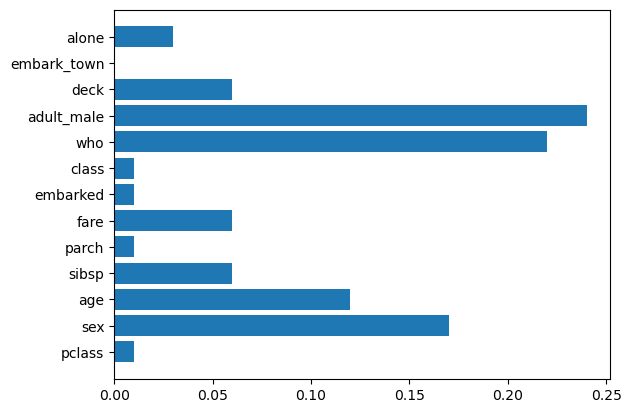

In [11]:
# 重要度可視化
plt.barh(X.columns, rf.feature_importances_)

[Text(0.5, 0.75, 'x[3] <= 0.5\ngini = 0.47\nsamples = 81\nvalue = [48, 79]'),
 Text(0.25, 0.25, 'gini = 0.495\nsamples = 54\nvalue = [39, 48]'),
 Text(0.75, 0.25, 'gini = 0.349\nsamples = 27\nvalue = [9, 31]')]

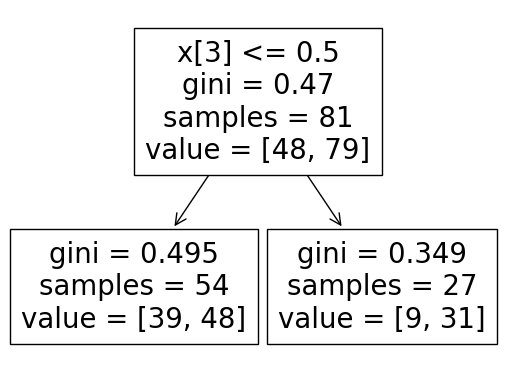

In [18]:
# 弱学習器の木構造を描画
from sklearn.tree import plot_tree
plot_tree(rf.estimators_[1])

## AdaBoost

Adaboost
- sklearn.ensemble.AdaboostClassifierクラス
    1. インスタンス生成
        - base_estimator: 使用する弱学習器のモデルクラス
            - 通常はDecisionTreeClassifierを使用（デフォルトはmax_depth=1）
        - n_estimators：　ブースティングの最大凍レーション数（デフォルトは50）
        - learning_rate：　学習率（デフォルトは1.0）
    2. .fit(X,y)で学習
    3. .predict(X)で予測

In [13]:
# データ準備
df = sns.load_dataset('titanic')

# 欠損値削除
df.dropna(inplace=True)

# X,y生成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

# ラベルエンコーディング
# .set_output(transform='pandas')：　oeがnumpyで返るのをpandasにする
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
oe.set_output(transform='pandas')
X[cat_cols] = oe.fit_transform(X[cat_cols])

# 学習/テストデータ分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/tmp/ipykernel_48/1260895635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = oe.fit_transform(X[cat_cols])


In [14]:
# Adaboostモデル学習
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)

# 予測
y_pred_ada = ada.predict_proba(X_test)

# AUC精度
print(f'Adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaboost AUC: 0.9375


<BarContainer object of 13 artists>

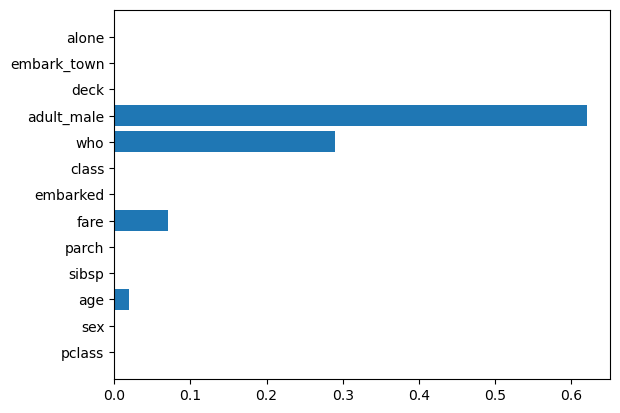

In [15]:
# 重要度可視化
plt.barh(X.columns, ada.feature_importances_)